In [1]:
import os
import zipfile
import torch
import numpy as np
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder

d:\Programs\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
dataset_path = r"D:\SRH\Master Thesis\Training_Data\Training_Data"
os.listdir(dataset_path)

['Computed Tomography (CT) Scan',
 'Endoscopy',
 'Histology',
 'Magnetic Resonance Imaging (MRI)',
 'Positron Emission Tomography (PET) Scan',
 'Ultrasound',
 'X-ray']

In [3]:
dataset = ImageFolder(dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor()
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

In [4]:
mean = 0.0
std = 0.0

for images, _ in dataloader:
    batch_mean = torch.mean(images, dim=(0, 2, 3))
    batch_std = torch.std(images, dim=(0, 2, 3))
    mean += batch_mean
    std += batch_std

mean /= len(dataloader)
std /= len(dataloader)

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: tensor([0.4614, 0.4271, 0.4310])
Standard Deviation: tensor([0.3192, 0.3154, 0.3157])


In [5]:
dataset = ImageFolder(dataset_path, transform=transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

In [6]:
class_counts = {}

for _, label in dataset:
    class_counts[label] = class_counts.get(label, 0) + 1

# Print the number of images in each class
for class_label, count in class_counts.items():
    class_name = dataset.classes[class_label]
    print(f"Class '{class_name}': {count} images")

Class 'Computed Tomography (CT) Scan': 1799 images
Class 'Endoscopy': 1418 images
Class 'Histology': 1277 images
Class 'Magnetic Resonance Imaging (MRI)': 1633 images
Class 'Positron Emission Tomography (PET) Scan': 1600 images
Class 'Ultrasound': 1099 images
Class 'X-ray': 786 images


In [7]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

In [8]:
# Calculate the class weights based on the number of images in each class
class_counts = Counter(dataset.targets)
class_weights = [1.0 / class_counts[label] for label in dataset.targets]

# Create a sampler that balances the dataset based on class weights
sampler = WeightedRandomSampler(class_weights, len(class_weights))

# Create a dataloader using the balanced sampler
balanced_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=sampler)
dataloader = balanced_dataloader

In [9]:
import random

In [10]:
# Get the length of the dataset
dataset_size = len(dataset)
print(dataset_size)

# Split the dataset into train and test
train_size = int(0.8 * dataset_size)
print(train_size)
test_size = dataset_size - train_size
print(test_size)

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)

# Create the train and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(random_seed))

# Create the train and test dataloaders
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

9612
7689
1923


In [11]:
labels = dataset.classes
label_mapping = {i: label for i, label in enumerate(labels)}

print("Labels:", labels)
print("Label Mapping:", label_mapping)

Labels: ['Computed Tomography (CT) Scan', 'Endoscopy', 'Histology', 'Magnetic Resonance Imaging (MRI)', 'Positron Emission Tomography (PET) Scan', 'Ultrasound', 'X-ray']
Label Mapping: {0: 'Computed Tomography (CT) Scan', 1: 'Endoscopy', 2: 'Histology', 3: 'Magnetic Resonance Imaging (MRI)', 4: 'Positron Emission Tomography (PET) Scan', 5: 'Ultrasound', 6: 'X-ray'}


In [12]:
def  show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels: ",labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  

tensor([1, 1, 0, 4, 2, 4])


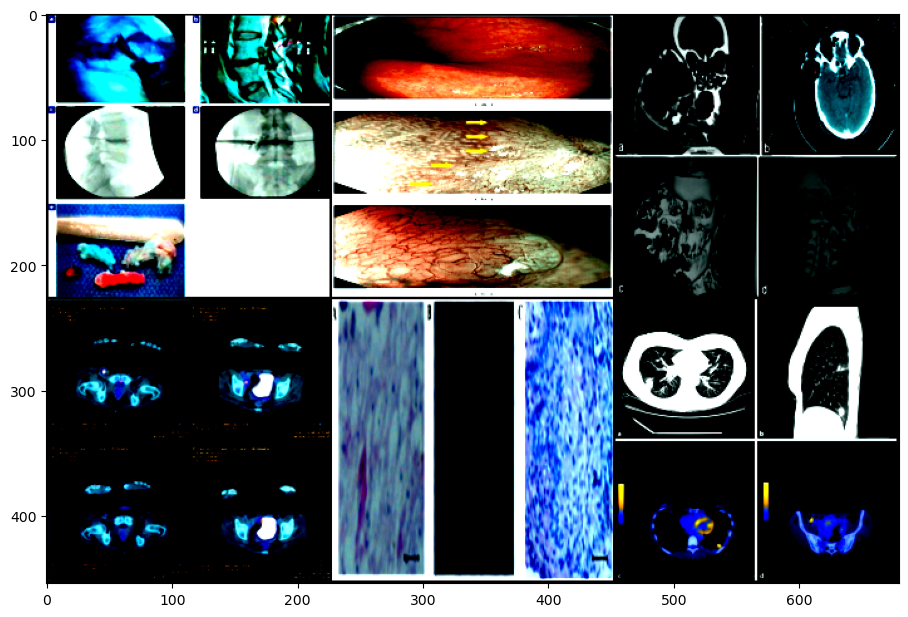

In [13]:
show_transformed_images(train_dataset)

In [14]:
train_load_data = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle=True)
test_load_data = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle=False)

In [15]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

device = set_device()
print(device)

cuda:0


In [16]:
def save_checkpoint(model, epoch, optimizer, best_accuracy, save_name):
    state = {
        'epoch' : epoch + 1,
        'model' : model.state_dict(),
        'best_accuracy' : best_accuracy,
        'optimizer' : optimizer.state_dict()
    }
    torch.save(state, save_name + 'model_best_checkpoint.pth.tar')

In [17]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly += (predicted == labels).sum().item()
            
    epoch_acc = 100.0 * predicted_correctly/total
    print("Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly, total, epoch_acc))
    return epoch_acc

In [18]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs, save_name):
    device = set_device()
    best_accuracy = 0
    training_results = {'model_name': save_name, 'epoch': [], 'train_acc': [], 'test_acc': [], 'epoch_loss': []}
    
    for epoch in range(n_epochs):
        print("Epoch number %d " % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print(
            " - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
            % (running_correct, total, epoch_acc, epoch_loss)
        )

        test_dataset_accuracy = evaluate_model_on_test_set(model, test_loader)

        if test_dataset_accuracy > best_accuracy:
            best_accuracy = test_dataset_accuracy
            save_checkpoint(model, epoch, optimizer, best_accuracy, save_name)

        training_results['epoch'].append(epoch + 1)
        training_results['train_acc'].append(epoch_acc)
        training_results['test_acc'].append(test_dataset_accuracy)
        training_results['epoch_loss'].append(epoch_loss)

    print("Finished")
    return model, training_results

In [19]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [20]:
n_epochs = 10
number_of_classes = 7
loss_function = nn.CrossEntropyLoss()

In [21]:
# resnet18_model
resnet18_model = models.resnet18(pretrained = True)
num_features_resnet18 = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_features_resnet18, number_of_classes)
resnet18_model_optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
resnet18_model = resnet18_model.to(device)
resnet18_model, resnet18_model_training_results = train_nn(resnet18_model, train_loader, test_loader, loss_function, resnet18_model_optimizer, n_epochs, "resnet18")
resnet18_model =None

d:\Programs\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programs\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 1 
 - Training dataset. Got 5263 out of 7689 images correctly (68.448%). Epoch loss: 0.971
Testing dataset. Got 1456 out of 1923 images correctly (75.715%)
Epoch number 2 
 - Training dataset. Got 6263 out of 7689 images correctly (81.454%). Epoch loss: 0.551
Testing dataset. Got 1412 out of 1923 images correctly (73.427%)
Epoch number 3 
 - Training dataset. Got 6639 out of 7689 images correctly (86.344%). Epoch loss: 0.401
Testing dataset. Got 1411 out of 1923 images correctly (73.375%)
Epoch number 4 
 - Training dataset. Got 6765 out of 7689 images correctly (87.983%). Epoch loss: 0.342
Testing dataset. Got 1312 out of 1923 images correctly (68.227%)
Epoch number 5 
 - Training dataset. Got 6825 out of 7689 images correctly (88.763%). Epoch loss: 0.322
Testing dataset. Got 1363 out of 1923 images correctly (70.879%)
Epoch number 6 
 - Training dataset. Got 7069 out of 7689 images correctly (91.937%). Epoch loss: 0.224
Testing dataset. Got 1365 out of 1923 images correc

In [22]:
# inceptionv3_model
# inceptionv3_model = models.inception_v3(pretrained=True)
# num_features_inceptionv3 = inceptionv3_model.fc.in_features
# inceptionv3_model.fc = nn.Linear(num_features_inceptionv3, number_of_classes)
# inceptionv3_model = inceptionv3_model.to(device)
# inceptionv3_model_optimizer = optim.SGD(inceptionv3_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
# inceptionv3_model = None

In [23]:
#densenet121_model
densenet121_model = models.densenet121(pretrained=True)
num_features_densenet121 = densenet121_model.classifier.in_features
densenet121_model.classifier = nn.Linear(num_features_densenet121, number_of_classes)
densenet121_model_optimizer = optim.SGD(densenet121_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
densenet121_model = densenet121_model.to(device)
densenet121_model, densenet121_model_training_results = train_nn(densenet121_model, train_loader, test_loader, loss_function, densenet121_model_optimizer, n_epochs, "densenet121")
densenet121_model = None

d:\Programs\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programs\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 1 
 - Training dataset. Got 5349 out of 7689 images correctly (69.567%). Epoch loss: 0.941
Testing dataset. Got 1408 out of 1923 images correctly (73.219%)
Epoch number 2 
 - Training dataset. Got 6181 out of 7689 images correctly (80.388%). Epoch loss: 0.588
Testing dataset. Got 1397 out of 1923 images correctly (72.647%)
Epoch number 3 
 - Training dataset. Got 6617 out of 7689 images correctly (86.058%). Epoch loss: 0.400
Testing dataset. Got 1405 out of 1923 images correctly (73.063%)
Epoch number 4 
 - Training dataset. Got 6809 out of 7689 images correctly (88.555%). Epoch loss: 0.338
Testing dataset. Got 1339 out of 1923 images correctly (69.631%)
Epoch number 5 
 - Training dataset. Got 6749 out of 7689 images correctly (87.775%). Epoch loss: 0.344
Testing dataset. Got 1384 out of 1923 images correctly (71.971%)
Epoch number 6 
 - Training dataset. Got 6885 out of 7689 images correctly (89.544%). Epoch loss: 0.295
Testing dataset. Got 1376 out of 1923 images correc

In [24]:
#mobilenetv2_model
mobilenetv2_model = models.mobilenet_v2(pretrained=True)
num_features_mobilenetv2 = mobilenetv2_model.classifier[1].in_features
mobilenetv2_model.classifier[1] = nn.Linear(num_features_mobilenetv2, number_of_classes)
mobilenetv2_model_optimizer = optim.SGD(mobilenetv2_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
mobilenetv2_model = mobilenetv2_model.to(device)
mobilenetv2_model, mobilenetv2_model_training_results = train_nn(mobilenetv2_model, train_loader, test_loader, loss_function, mobilenetv2_model_optimizer, n_epochs, "mobilenetv2")
mobilenetv2_model = None

d:\Programs\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 1 
 - Training dataset. Got 5283 out of 7689 images correctly (68.709%). Epoch loss: 0.948
Testing dataset. Got 1403 out of 1923 images correctly (72.959%)
Epoch number 2 
 - Training dataset. Got 6009 out of 7689 images correctly (78.151%). Epoch loss: 0.670
Testing dataset. Got 1420 out of 1923 images correctly (73.843%)
Epoch number 3 
 - Training dataset. Got 6362 out of 7689 images correctly (82.742%). Epoch loss: 0.522
Testing dataset. Got 1359 out of 1923 images correctly (70.671%)
Epoch number 4 
 - Training dataset. Got 6489 out of 7689 images correctly (84.393%). Epoch loss: 0.455
Testing dataset. Got 1381 out of 1923 images correctly (71.815%)
Epoch number 5 
 - Training dataset. Got 6490 out of 7689 images correctly (84.406%). Epoch loss: 0.448
Testing dataset. Got 1319 out of 1923 images correctly (68.591%)
Epoch number 6 
 - Training dataset. Got 6634 out of 7689 images correctly (86.279%). Epoch loss: 0.393
Testing dataset. Got 1369 out of 1923 images correc

In [25]:
# vgg16_model
vgg16_model = models.vgg16(pretrained=True)
num_features_vgg16 = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_features_vgg16, number_of_classes)
vgg16_model_optimizer = optim.SGD(vgg16_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
vgg16_model = vgg16_model.to(device)
vgg16_model, vgg16_model_training_results = train_nn(vgg16_model, train_loader, test_loader, loss_function, vgg16_model_optimizer, n_epochs, "vgg16")
vgg16_model = None

d:\Programs\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch number 1 
 - Training dataset. Got 5033 out of 7689 images correctly (65.457%). Epoch loss: 1.018
Testing dataset. Got 1371 out of 1923 images correctly (71.295%)
Epoch number 2 
 - Training dataset. Got 5938 out of 7689 images correctly (77.227%). Epoch loss: 0.697
Testing dataset. Got 1430 out of 1923 images correctly (74.363%)
Epoch number 3 
 - Training dataset. Got 6274 out of 7689 images correctly (81.597%). Epoch loss: 0.560
Testing dataset. Got 1481 out of 1923 images correctly (77.015%)
Epoch number 4 
 - Training dataset. Got 6399 out of 7689 images correctly (83.223%). Epoch loss: 0.496
Testing dataset. Got 1448 out of 1923 images correctly (75.299%)
Epoch number 5 
 - Training dataset. Got 6552 out of 7689 images correctly (85.213%). Epoch loss: 0.426
Testing dataset. Got 1390 out of 1923 images correctly (72.283%)
Epoch number 6 
 - Training dataset. Got 6615 out of 7689 images correctly (86.032%). Epoch loss: 0.399
Testing dataset. Got 1430 out of 1923 images correc

In [26]:
# Create an empty dictionary to store the combined training results
combined_results = {}

# Merge the training results into the combined_results dictionary
combined_results['resnet18'] = resnet18_model_training_results
combined_results['densenet121'] = densenet121_model_training_results
combined_results['mobilenetv2'] = mobilenetv2_model_training_results
combined_results['vgg16'] = vgg16_model_training_results